# 

In [14]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import collections
import sys
import textwrap
import warnings
from functools import partial, reduce
from importlib import reload
from pathlib import Path
from pprint import pprint

import clip
import matplotlib.pyplot
import matplotlib.pyplot as plt
import medmnist
import numpy as np
import pandas as pd
import torch

sys.path.append("../src")
import clip
import valuation
from opendataval.dataloader import DataFetcher
from opendataval.dataval import (
    DataOob,
    DataShapley,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)
from opendataval.model import ClassifierSkLearnWrapper, RegressionSkLearnWrapper
from PIL import Image
from scipy.stats import kendalltau, pearsonr
from sklearn import random_projection
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    DistanceMetric,
    accuracy_score,
    adjusted_mutual_info_score,
    f1_score,
    v_measure_score,
)
from sklearn.metrics.cluster import homogeneity_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
from vendi_score import vendi

plt.rcParams["font.family"] = "serif"
fig_dir = Path("figures")
from collections import defaultdict

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [15]:
saved_embedding_path = Path("../embeddings")

clean_med = {
    "bloodmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224.pt"
    ),
    "breastmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_breastmnist_224.pt"
    ),
    "chestmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_chestmnist_224.pt"
    ),
    "dermamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_dermamnist_224.pt"
    ),
    "pathmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_pathmnist_224.pt"
    ),
    "retinamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_retinamnist_224.pt"
    ),
    "tissuemnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_tissuemnist_224.pt"
    ),
    "organamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_organamnist_224.pt"
    ),
}


# Noisy version that is low pass filtered and cropped
noise_med = {
    "bloodmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224_noise.pt"
    ),
    "breastmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_breastmnist_224_noise.pt"
    ),
    "chestmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_chestmnist_224_noise.pt"
    ),
    "dermamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_dermamnist_224_noise.pt"
    ),
    "pathmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_pathmnist_224_noise.pt"
    ),
    "retinamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_retinamnist_224_noise.pt"
    ),
    "tissuemnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_tissuemnist_224_noise.pt"
    ),
    "organamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_organamnist_224_noise.pt"
    ),
}

In [16]:
# Mixture of all medmnist datasets
med = torch.cat(
    [
        v["embeddings"][: int(10000 / 5)]
        for k, v in clean_med.items()
    ]
)
med = med[torch.randperm(med.size(0))]

In [17]:
# Other irrelevant datasets to compare
cifar = torch.load(saved_embedding_path / "clip_embedding_cifar_seller.pt")
fashion = torch.load(saved_embedding_path / "clip_embedding_fashion_seller.pt")
mnist = torch.load(saved_embedding_path / "clip_embedding_mnist_seller.pt")

## Qualitative experiments

### Visually compare different combinations of diversity and relevance

In [18]:
n_buy = 100
n_sell = 10000

# buyer = "bloodmnist"
# buyer = 'chestmnist'
# buyer = 'pathmnist'
buyer = 'tissuemnist'
# buyer = 'dermamnist'
# buyer = 'organamnist'
# buyer = 'retinamnist'

sellers = list(set(clean_med.keys()) - set([buyer]))
n_buy = 100
n_sell = 3000
buyer_data = clean_med[buyer]["embeddings"][-n_buy:]
sellers_data = {s: clean_med[s]['embeddings'][:n_sell] for s in sellers}
sellers_data['IID'] = clean_med[buyer]["embeddings"][:n_sell]
sellers_data['mnist'] = mnist["images"][:n_sell]
# sellers_data['fashion'] = fashion["images"][:n_sell]
sellers_data['cifar'] = cifar["images"][:n_sell]

seller_values = {
    k: valuation.get_value(
        buyer_data,
        v,
        # cifar['images'][-100:], v,
        n_components=10,
        # normalize=True,
        use_neg_components=True,
        # use_dp=True,
        # dp_epsilon=0.1,
        # dp_delta=1e6,
    )
    for k, v in tqdm(sellers_data.items())
}

  0%|          | 0/10 [00:00<?, ?it/s]

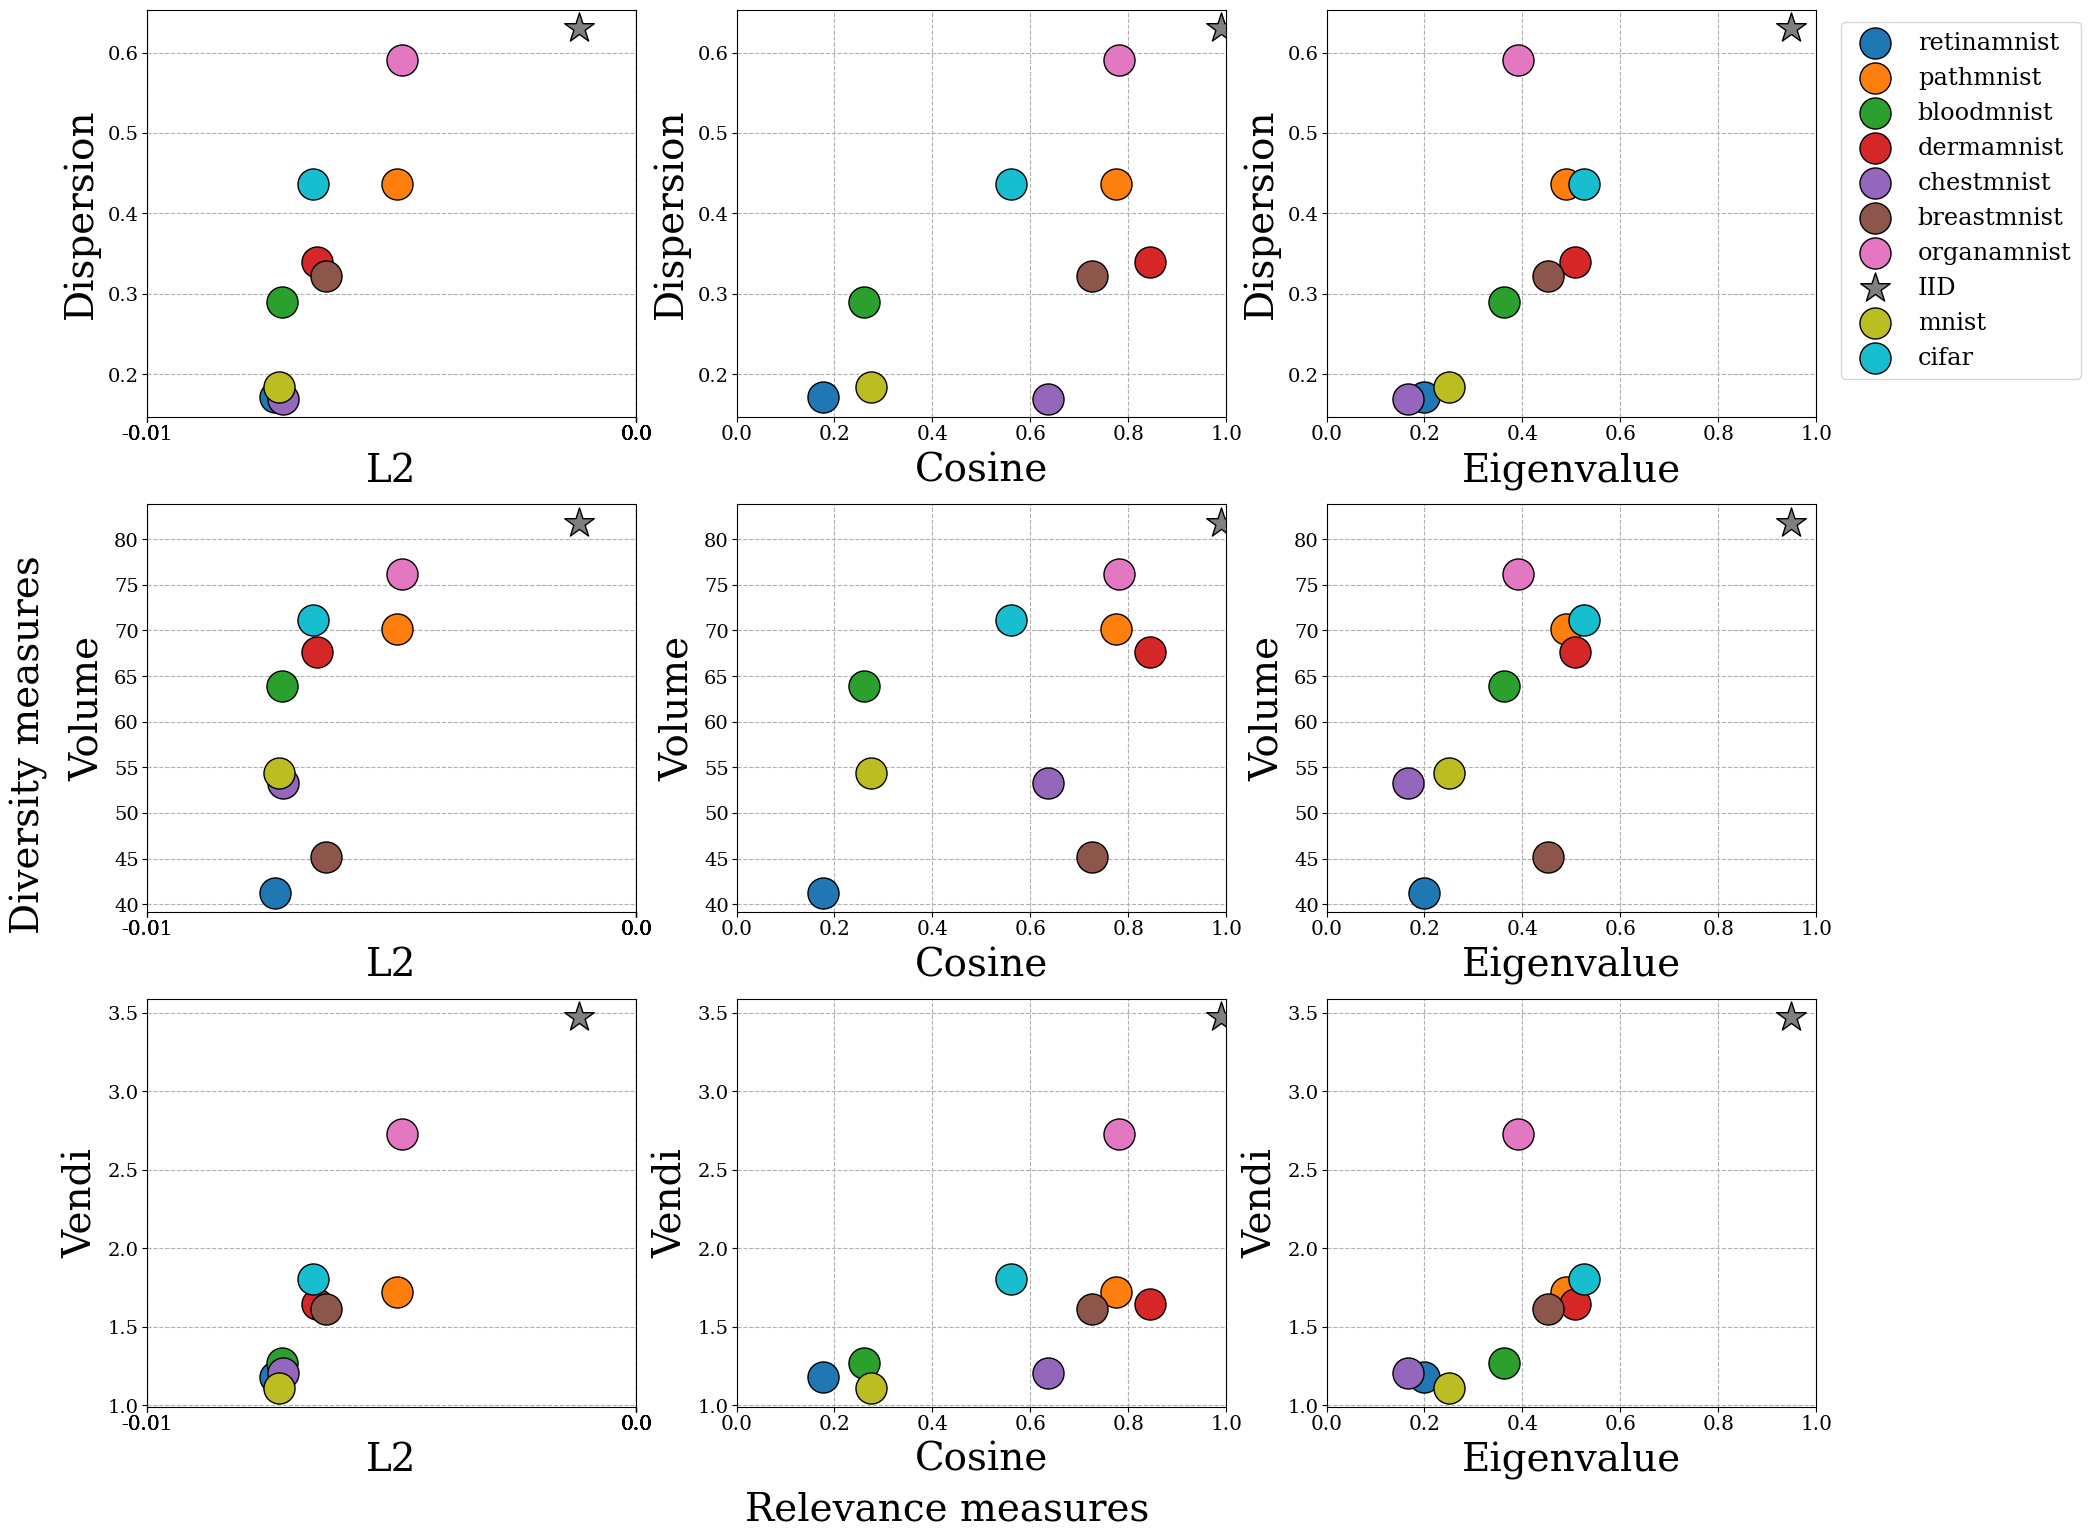

In [19]:
fontsize = 28
size = 500

fig, axs = plt.subplots(3, 3, figsize=(18, 15))

for i, (k, v) in enumerate(seller_values.items()):
   
    marker = '*'  if k == 'IID' else 'o'

    scatter_kwargs = dict(edgecolor="k", s=size, zorder=2, marker=marker)
    rel = v["relevance"]
    l2 = v["l2"]
    cos = v["cosine"]
    ven = v["vendi"]
    vol = v["volume"]
    dis = v["dispersion"]  

    axs[0, 0].scatter(l2, dis, label=k, **scatter_kwargs)
    axs[1, 0].scatter(l2, vol, **scatter_kwargs)
    axs[2, 0].scatter(l2, ven, **scatter_kwargs)
    axs[0, 1].scatter(cos, dis, **scatter_kwargs)
    axs[1, 1].scatter(cos, vol, **scatter_kwargs)
    axs[2, 1].scatter(cos, ven, **scatter_kwargs)
    axs[0, 2].scatter(rel, dis, **scatter_kwargs)
    axs[1, 2].scatter(rel, vol, **scatter_kwargs)
    axs[2, 2].scatter(rel, ven, **scatter_kwargs)

axs[0, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[1, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[2, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[0, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[1, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[2, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[0, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[1, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[2, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[0, 0].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 1].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 2].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[1, 0].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 1].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 2].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[2, 0].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 1].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 2].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)


fig.text(0.5, -0.01, "Relevance measures", ha="center", va="center", fontsize=fontsize)
fig.text(
    -0.01,
    0.5,
    "Diversity measures",
    ha="center",
    va="center",
    fontsize=fontsize,
    rotation=90,
)

for ax in axs.flat:
    # ax.set_xlim(0, 1)
    ax.tick_params(axis="both", labelsize=14, pad=2)
    
    if ax.get_xlabel() != 'L2':
        ax.set_xlim(right=1)
    ax.set_xticks([round(x, 2) for x in ax.get_xticks()])
    ax.set_xticklabels(ax.get_xticks(), fontsize="x-large")
    ax.grid(ls="--", zorder=0)
    # ax.set_xlabel("Relevance", fontsize=fontsize, labelpad=6)
    # ax.set_ylabel("Difference", fontsize=fontsize, labelpad=6)
    # ax

# fig.legend(bbox_to_anchor=(0.15, -0.03), loc='upper left', fontsize='xx-large', ncols=4)
fig.legend(bbox_to_anchor=(0.99, 0.99), loc="upper left", fontsize="xx-large", ncols=1)
fig.tight_layout(h_pad=1, w_pad=0)
# plt.savefig(fig_dir / f"{buyer}.eps", bbox_inches='tight')

### Interpolate between domains (in-domain versus out of domain)

In [20]:
def interpolate(a, b, num_samples=10000, num_parts=10):
    """ 
    Interpolate number samples between two datasets
    Return dictionary with `num_parts` datasets with 
    varying proportions of dataset `a` and `b`
    starting with 1 part `a` and 9 parts `b`
    and ending with 10 parts `b`
    """
    n = int(min(len(a), len(b), num_samples) / num_parts)
    ret = {
        j: torch.cat([a[: n * (num_parts - j)], b[: n * j]])
        for j in range(1, num_parts + 1)
    }
    return ret


In [25]:
sellers = {}
num_parts = 10
parts = 100 // num_parts

for k, v in interpolate(
    clean_med[buyer]["embeddings"][:n_sell],
    noise_med[buyer]["embeddings"][:n_sell],
).items():
    sellers[f"{parts * k}% Noisy {buyer.capitalize()}"] = v

for k, v in interpolate(
    clean_med[buyer]["embeddings"][:n_sell], 
    med[:n_sell], num_parts=num_parts
).items():
    sellers[f"{parts * k}% MedMNIST"] = v

for k, v in interpolate(
    clean_med[buyer]["embeddings"][:n_sell],
    mnist["images"][:n_sell],
    num_parts=num_parts,
).items():
    sellers[f"{parts * k}% MNIST"] = v

for k, v in interpolate(
    clean_med[buyer]["embeddings"][:n_sell],
    cifar["images"][:n_sell],
    num_parts=num_parts,
).items():
    sellers[f"{parts * k}% CIFAR"] = v

interp_seller_values = {
    k: valuation.get_value(
        buyer_data,
        v,
        n_components=10,
        # normalize=True,
        use_neg_components=True,
    )
    for k, v in tqdm(sellers.items())
}

  0%|          | 0/40 [00:00<?, ?it/s]

10% Noisy Tissuemnist
20% Noisy Tissuemnist
30% Noisy Tissuemnist
40% Noisy Tissuemnist
50% Noisy Tissuemnist
60% Noisy Tissuemnist
70% Noisy Tissuemnist
80% Noisy Tissuemnist
90% Noisy Tissuemnist
100% Noisy Tissuemnist
10% MedMNIST
20% MedMNIST
30% MedMNIST
40% MedMNIST
50% MedMNIST
60% MedMNIST
70% MedMNIST
80% MedMNIST
90% MedMNIST
100% MedMNIST
10% MNIST
20% MNIST
30% MNIST
40% MNIST
50% MNIST
60% MNIST
70% MNIST
80% MNIST
90% MNIST
100% MNIST
10% CIFAR
20% CIFAR
30% CIFAR
40% CIFAR
50% CIFAR
60% CIFAR
70% CIFAR
80% CIFAR
90% CIFAR
100% CIFAR


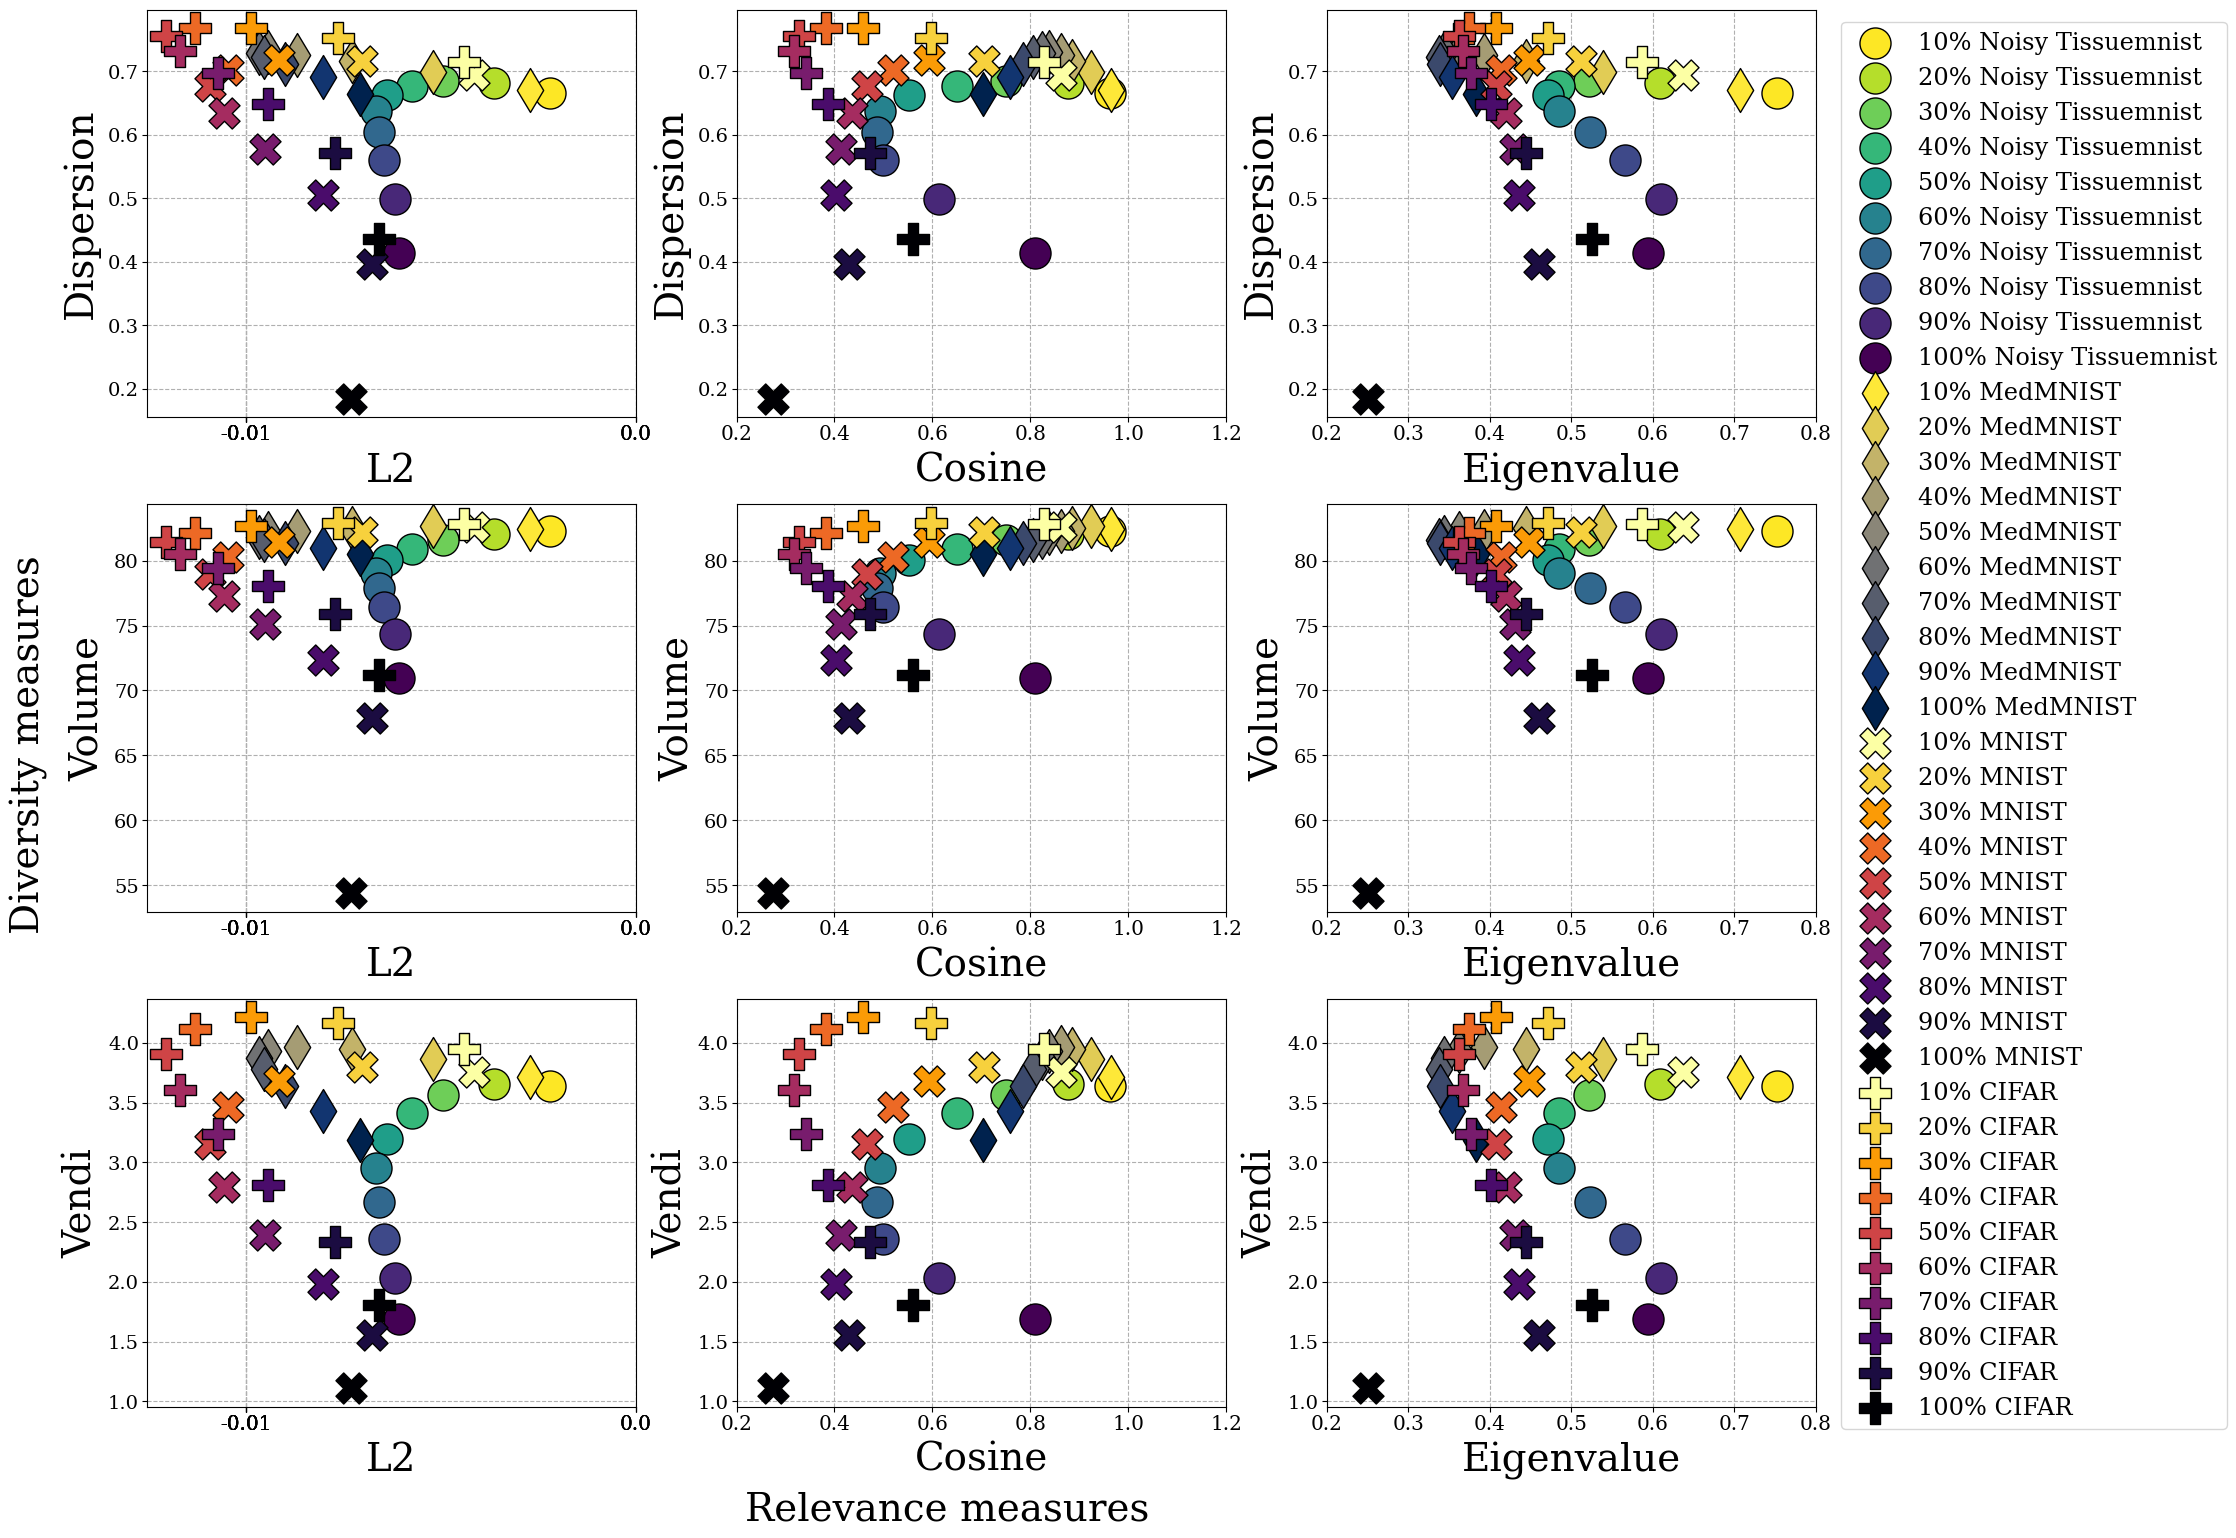

In [37]:

num = 10
# cmap1 = plt.cm.inferno
# cmap1 = cmap1(np.linspace(0.1, 1, 10))
# cmap2 = plt.cm.viridis
# cmap2 = cmap2(np.linspace(0.1, 1, 10))
# cmap3 = plt.cm.cividis
# cmap3 = cmap3(np.linspace(0.1, 1, 10))

rang = np.linspace(1, 0, num)
greens = plt.cm.YlGn(rang)
viridis = plt.cm.viridis(rang)
cividis = plt.cm.cividis(rang)
plasma = plt.cm.inferno(rang)
magma = plt.cm.inferno(rang)

cmap = plt.cm.viridis
colors = cmap(np.linspace(0.2, 1, len(seller_values)))

fontsize = 28
size = 500

fig, axs = plt.subplots(3, 3, figsize=(18, 15))

for i, (k, v) in enumerate(interp_seller_values.items()):
    print(k)

    match k:
        case str(name) if name == buyer.capitalize():
            marker = "*"
            c = "darkgray"
            s = size + 100
        case str(name) if "noisy" in name.lower():
            # j = (int(name.split()[0][:-1]) // num) -1
            marker = "o"
            # c = greens[~j]
            c = viridis[i % num]
            s = size
        case str(name) if name.split()[1] == "MedMNIST":
            # j = (int(name.split()[0][:-1]) // num) -1
            c = cividis[i % num]
            marker = "d"
            s = size
        case str(name) if name.split()[1] == "MNIST":
            # j = (int(name.split()[0][:-1]) // num) -1
            c = plasma[i % num]
            marker = "X"
            s = size
        case str(name) if "cifar" in name.lower():
            # j = (int(name.split()[0][:-1]) // num) -1
            c = magma[i % num]
            marker = "P"
            s = size
        case _:
            print(k)
            raise

    scatter_kwargs = dict(color=c, edgecolor="k", s=s, zorder=2, marker=marker)
    # cos = (1 + v['cosine']) - (1 + v['neg_cosine'])
    cos = v["cosine"]
    ven = v["vendi"]
    vol = v["volume"]
    dis = v["dispersion"]  # - v['neg_dispersion']

    axs[0, 0].scatter(v["l2"], dis, label=k, **scatter_kwargs)
    axs[1, 0].scatter(v["l2"], vol, **scatter_kwargs)
    axs[2, 0].scatter(v["l2"], ven, **scatter_kwargs)
    axs[0, 1].scatter(cos, dis, **scatter_kwargs)
    axs[1, 1].scatter(cos, vol, **scatter_kwargs)
    axs[2, 1].scatter(cos, ven, **scatter_kwargs)
    axs[0, 2].scatter(v["relevance"], dis, **scatter_kwargs)
    axs[1, 2].scatter(v["relevance"], vol, **scatter_kwargs)
    axs[2, 2].scatter(v["relevance"], ven, **scatter_kwargs)

axs[0, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[1, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[2, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[0, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[1, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[2, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[0, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[1, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[2, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[0, 0].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 1].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 2].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[1, 0].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 1].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 2].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[2, 0].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 1].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 2].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)


fig.text(0.5, -0.01, "Relevance measures", ha="center", va="center", fontsize=fontsize)
fig.text(
    -0.01,
    0.5,
    "Diversity measures",
    ha="center",
    va="center",
    fontsize=fontsize,
    rotation=90,
)

for ax in axs.flat:
    ax.tick_params(axis="both", labelsize=14, pad=2)
    ax.grid(ls="--", zorder=0)
    ax.set_xticks([round(x, 2) for x in ax.get_xticks()])
    ax.set_xticklabels(ax.get_xticks(), fontsize="x-large")
    
    # ax.set_xlabel("Relevance", fontsize=fontsize, labelpad=6)
    # ax.set_ylabel("Difference", fontsize=fontsize, labelpad=6)
    # ax

# fig.legend(bbox_to_anchor=(0.15, -0.03), loc='upper left', fontsize='xx-large', ncols=4)
fig.legend(bbox_to_anchor=(0.99, 0.99), loc="upper left", fontsize="xx-large", ncols=1)
fig.tight_layout(h_pad=1, w_pad=0)
# plt.savefig(fig_dir / f"{buyer}.eps", bbox_inches='tight')

### False projections

In [38]:
sellers = list(set(clean_med.keys()) - set([buyer]))
n_buy = 100
n_sell = 3000
buyer_data = clean_med[buyer]["embeddings"][-n_buy:]
u1 = valuation.get_value(buyer_data, clean_med[buyer]["embeddings"][:n_sell])
u2 = valuation.get_value(buyer_data, clean_med[sellers[0]]["embeddings"][:n_sell])
u3 = valuation.get_value(buyer_data, clean_med[sellers[1]]["embeddings"][:n_sell])
u4 = valuation.get_value(buyer_data, clean_med[sellers[2]]["embeddings"][:n_sell])
u5 = valuation.get_value(buyer_data, clean_med[sellers[3]]["embeddings"][:n_sell])
u6 = valuation.get_value(buyer_data, cifar["images"][:n_sell])

false_data = fashion["images"][-n_buy:]
v1 = valuation.get_value(false_data, clean_med[buyer]["embeddings"][:n_sell])
v2 = valuation.get_value(false_data, clean_med[sellers[0]]["embeddings"][:n_sell])
v3 = valuation.get_value(false_data, clean_med[sellers[1]]["embeddings"][:n_sell])
v4 = valuation.get_value(false_data, clean_med[sellers[2]]["embeddings"][:n_sell])
v5 = valuation.get_value(false_data, clean_med[sellers[3]]["embeddings"][:n_sell])
v6 = valuation.get_value(false_data, cifar["images"][:n_sell])

random_data = np.exp(np.random.exponential(size=(100, 512), scale=0.2))
w1 = valuation.get_value(random_data, clean_med[buyer]["embeddings"][:n_sell])
w2 = valuation.get_value(random_data, clean_med[sellers[0]]["embeddings"][:n_sell])
w3 = valuation.get_value(random_data, clean_med[sellers[1]]["embeddings"][:n_sell])
w4 = valuation.get_value(random_data, clean_med[sellers[2]]["embeddings"][:n_sell])
w5 = valuation.get_value(random_data, clean_med[sellers[3]]["embeddings"][:n_sell])
w6 = valuation.get_value(random_data, cifar["images"][:n_sell])

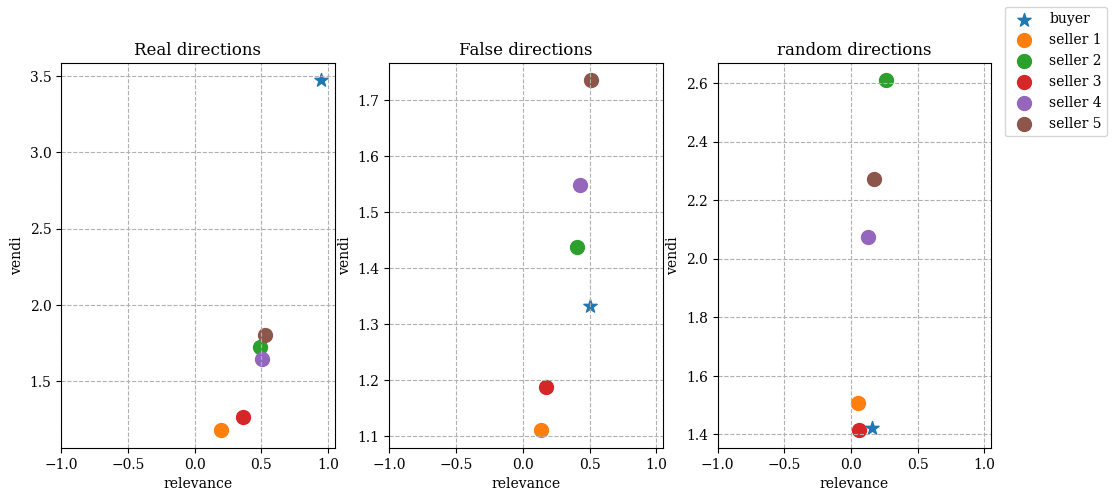

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
div = 'vendi'
rel = 'relevance'

markersize = 100
ax[0].set_title("Real directions")
ax[0].scatter(u1[rel], u1[div], marker="*", label="buyer", s=markersize)
ax[0].scatter(u2[rel], u2[div], label="seller 1", s=markersize)
ax[0].scatter(u3[rel], u3[div], label="seller 2", s=markersize)
ax[0].scatter(u4[rel], u4[div], label="seller 3", s=markersize)
ax[0].scatter(u5[rel], u5[div], label="seller 4", s=markersize)
ax[0].scatter(u6[rel], u6[div], label="seller 5", s=markersize)
ax[1].set_title("False directions")
ax[1].scatter(v1[rel], v1[div], marker="*", s=markersize)
ax[1].scatter(v2[rel], v2[div], s=markersize)
ax[1].scatter(v3[rel], v3[div], s=markersize)
ax[1].scatter(v4[rel], v4[div], s=markersize)
ax[1].scatter(v5[rel], v5[div], s=markersize)
ax[1].scatter(v6[rel], v6[div], s=markersize)
ax[2].set_title("random directions")
ax[2].scatter(w1[rel], w1[div], marker="*", s=markersize)
ax[2].scatter(w2[rel], w2[div], s=markersize)
ax[2].scatter(w3[rel], w3[div], s=markersize)
ax[2].scatter(w4[rel], w4[div], s=markersize)
ax[2].scatter(w5[rel], w5[div], s=markersize)
ax[2].scatter(w6[rel], w6[div], s=markersize)
for _ax in ax:
    _ax.set_xlabel(rel)
    _ax.set_ylabel(div)
    _ax.set_xlim(-1, 1.05)
    # _ax.set_ylim(25, 100)
    _ax.grid(ls="--")
fig.legend()

## Quantitative experiments

In [30]:
# Subset of classes that the buyer cares about
# Both buyer query and test set will come from this subset of labels
sev_classes = {
    "pathmnist": [8, 7, 6],
    "dermamnist": [4, 1, 0],
    "bloodmnist": [6, 5, 4],
    "chestmnist": [6, 7],
    "breastmnist": [0],
    "tissuemnist": [2, 5, 6],
    "retinamnist": [1, 2, 3],
    "organamnist": [7, 8, 3, 6],
}

In [31]:
total_classes = {k: len(v["label"]) for k, v in medmnist.INFO.items()}
total_classes

{'pathmnist': 9,
 'chestmnist': 14,
 'dermamnist': 7,
 'octmnist': 4,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'breastmnist': 2,
 'bloodmnist': 8,
 'tissuemnist': 8,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'organmnist3d': 11,
 'nodulemnist3d': 2,
 'adrenalmnist3d': 2,
 'fracturemnist3d': 3,
 'vesselmnist3d': 2,
 'synapsemnist3d': 2}

In [32]:
for k, v in medmnist.INFO.items():
    if k in sev_classes:
        print(k.upper(), [v["label"][str(a)] for a in sev_classes[k]])

PATHMNIST ['colorectal adenocarcinoma epithelium', 'cancer-associated stroma', 'normal colon mucosa']
CHESTMNIST ['pneumonia', 'pneumothorax']
DERMAMNIST ['melanoma', 'basal cell carcinoma', 'actinic keratoses and intraepithelial carcinoma']
RETINAMNIST ['1', '2', '3']
BREASTMNIST ['malignant']
BLOODMNIST ['neutrophil', 'monocyte', 'lymphocyte']
TISSUEMNIST ['Glomerular endothelial cells', 'Podocytes', 'Proximal Tubule Segments']
ORGANAMNIST ['lung-left', 'lung-right', 'heart', 'liver']


In [33]:
def sample_dirichlet_by_class(
    x, y, num_sellers=10, num_samples=1000, add_to_alpha=1, min_samples=0
):
    """
    Sample seller data according to dirichlet class distribution
    taking into consideration class frequency
    """
    y = y.squeeze().numpy()
    class_counts = np.bincount(y)
    class_prop = class_counts / class_counts.sum()
    class_weights = np.random.dirichlet(add_to_alpha + class_prop, size=num_sellers)
    sample_weights = {i: v[y] for i, v in enumerate(class_weights)}
    sample_weights = {k: v / v.sum() for k, v in sample_weights.items()}

    rang = np.arange(len(x))
    seller_indexes = {
        k: np.random.choice(rang, size=num_samples, replace=False, p=v)
        for k, v in sample_weights.items()
    }
    if min_samples > 0:
        new_index = []
        for c in np.unique(y):
            class_index = np.where(y == c)[0][:min_samples]
            new_index.extend(class_index)

        for k in seller_indexes:
            seller_indexes[k][: len(new_index)] = new_index

    return seller_indexes

In [34]:
def compute_utility(
    x_train,
    y_train,
    x_test,
    y_test,
    model=partial(LogisticRegression, max_iter=200),
    # utility=accuracy_score,
    utility=partial(f1_score, average="macro"),
    # utility=partial(f1_score, average=None),
    n_clusters=None,
):
    if n_clusters is not None:
        M = model(n_clusters=n_clusters)
    else:
        M = model()
    M.fit(x_train, y_train)
    y_pred = M.predict(x_test)
    return utility(y_test, y_pred)


binary_utility = partial(
    compute_utility,
    model=partial(LogisticRegression, max_iter=200),
    utility=partial(f1_score, average="macro"),
)
multi_utility = partial(
    compute_utility,
    model=partial(RandomForestClassifier, n_estimators=10, max_depth=5),
    utility=partial(f1_score, average="macro"),
)
cluster_utility = partial(
    compute_utility,
    model=partial(KMeans, n_clusters=10, n_init="auto"),
    utility=lambda true, pred: homogeneity_score(true.squeeze(), pred.squeeze()),
)

In [ ]:
datasets = [
    "bloodmnist",
    "dermamnist",
    "retinamnist",
    "breastmnist",
    "pathmnist",
    "tissuemnist",
    "organamnist",
]

results = defaultdict(dict)

for d in datasets:
    x = clean_med[d]["embeddings"].float()
    y = clean_med[d]["labels"]

    if d == "breastmnist":
        num_buyer = 50
        num_samples = 250
        print("breast")
    elif d == "dermamnist":
        num_buyer = 100
        num_samples = 1500
        print("derma")
    elif d == "pathmnist":
        num_buyer = 100
        num_samples = 1500
        print("path")
    elif d == "retinamnist":
        num_buyer = 100
        num_samples = 500
        print("retina")
    elif d == "Tissuemnist":
        num_buyer = 1500
        num_samples = 25000
        print("tissue")
    else:
        num_buyer = 500
        num_samples = 5000
        print("other")

    x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.3)
    print(x_dev.shape, x_test.shape)

    cs = torch.tensor(sev_classes[d])

    if d == "chestmnist":
        buyer_index = reduce(
            torch.logical_or, torch.chunk(y_test[:, cs], len(cs), dim=1)
        ).flatten()
    else:
        buyer_index = torch.isin(y_test.squeeze(), cs)

    x_buyer = x_test[buyer_index][:num_buyer]
    y_buyer = y_test[buyer_index][:num_buyer]

    class_bc = []
    vs = []
    bin_us = []
    multi_us = []
    cluster_us = []
    num_corr_class = []

    for i, (k, v) in tqdm(
        enumerate(
            sample_dirichlet_by_class(
                x_dev,
                y_dev,
                num_sellers=500,
                num_samples=num_samples,
                add_to_alpha=0.2,
                min_samples=1,
            ).items()
        )
    ):
        x_k = x_dev[v]
        y_k = y_dev.squeeze()[v]

        bc = np.bincount(y_k, minlength=total_classes[d])
        class_bc.append(bc)

        total = 0
        for c in cs:
            total += bc[c]
        num_corr_class.append(total)

        v = valuation.get_value(x_buyer, x_k)
        vs.append(v)

        bin_u = binary_utility(
            x_k,
            torch.isin(y_k, cs),
            x_test,
            buyer_index,
        )

        multi_u = multi_utility(
            x_k,
            y_k,
            x_test,
            y_test,
        )

        cluster_u = cluster_utility(
            x_k,
            y_k,
            x_test,
            y_test,
            n_clusters=len(sev_classes[d]),
        )

        bin_us.append(bin_u)
        multi_us.append(multi_u)
        cluster_us.append(cluster_u)

        if i % 20 == 0:
            print(
                k,
                bc,
                f"{bin_u:.2f}",
                f"{multi_u:.2f}",
                f"{cluster_u:.2f}",
                {k: round(v_, 2) for k, v_ in v.items()},
            )

    results[d]["class_bc"] = class_bc
    results[d]["vs"] = vs
    results[d]["bin_us"] = bin_us
    results[d]["multi_us"] = multi_us
    results[d]["cluster_us"] = cluster_us
    results[d]["num_corr_class"] = num_corr_class

other
torch.Size([8371, 512]) torch.Size([3588, 512])


0it [00:00, ?it/s]

0 [  41 1515    1 1106   64    7 1133 1133] 0.81 0.37 0.24 {'relevance': 0.73, 'l2': -0.0, 'cosine': 0.92, 'diversity': 0.12, 'volume': 82.04, 'vendi': 3.27, 'dispersion': 0.51}
20 [ 170  750  746   14  576  636 1622  486] 0.85 0.49 0.21 {'relevance': 0.82, 'l2': -0.0, 'cosine': 0.98, 'diversity': 0.12, 'volume': 82.97, 'vendi': 3.65, 'dispersion': 0.52}
40 [ 592 1527   11    7  589  290 1290  694] 0.81 0.47 0.22 {'relevance': 0.8, 'l2': -0.0, 'cosine': 0.96, 'diversity': 0.11, 'volume': 82.36, 'vendi': 3.43, 'dispersion': 0.51}
60 [ 592 1463  504 1305    8  149  165  814] 0.80 0.39 0.25 {'relevance': 0.77, 'l2': -0.0, 'cosine': 0.91, 'diversity': 0.1, 'volume': 81.9, 'vendi': 3.18, 'dispersion': 0.51}
80 [ 320  150  468 1377   36  238 1428  983] 0.85 0.35 0.25 {'relevance': 0.77, 'l2': -0.0, 'cosine': 0.95, 'diversity': 0.16, 'volume': 82.65, 'vendi': 3.41, 'dispersion': 0.52}
100 [   8 1366  567  795  305  430 1481   48] 0.91 0.44 0.22 {'relevance': 0.87, 'l2': -0.0, 'cosine': 0.99, 

In [ ]:
d = "bloodmnist"
d = "dermamnist"
# d = "retinamnist"
# d = "pathmnist"
# d = 'tissuemnist'
# d = 'organamnist'

class_bc = results[d]["class_bc"]
vs = results[d]["vs"]
bin_us = results[d]["bin_us"]
multi_us = results[d]["multi_us"]
cluster_us = results[d]["cluster_us"]
num_corr_class = results[d]["num_corr_class"]

# _x = [v["l2"] for v in vs]
# _x = [v["cosine"] for v in vs]
# _x = [v["relevance"] for v in vs]
# _x = [v["dispersion"] for v in vs]
_x = [v["volume"] for v in vs]
# _x = [v["vendi"] for v in vs]
# _x = num_corr_class
# _y = bin_us
_y = multi_us
# _y = cluster_us

coefficients = np.polyfit(_x, _y, 10)  # Fit the polynomial (degree 2)
polynomial = np.poly1d(
    coefficients
)  # Create a polynomial function with the fitted coefficients
x_fit = np.linspace(
    min(_x), max(_x), 100
)  # Generate x values for plotting the polynomial fit
y_fit = polynomial(x_fit)
# r = pearsonr(_x, _y)
r = kendalltau(_x, _y)
plt.figure(figsize=(6, 4))
plt.plot(x_fit, y_fit, color="red", label="Fitted polynomial curve", ls="--")
plt.scatter(
    _x,
    _y,
    label=rf"Rank correlation $\tau$={round(r.statistic, 2)}",
    edgecolors="k",
    lw=0.5,
)
plt.title(f"r={round(r.statistic, 2)}    pval={round(r.pvalue, 6)}")
# plt.title(fr"$\tau$={round(r.statistic, 2)}", fontsize=14)
plt.grid()
# plt.xlabel('Data measurement', fontsize=14)
# plt.xlabel('Relevance', fontsize=14)
plt.xlabel("Volume", fontsize=14)
# plt.xlabel('Number of data points with relevant labels', fontsize=14)
plt.ylabel("Prediction accuracy", fontsize=14)
# plt.ylim(0.0, 1)
plt.legend(fontsize=14, bbox_to_anchor=(1, 1))
# plt.savefig(fig_dir / f"{d}_correlation_multi.eps", bbox_inches='tight')
# plt.savefig(fig_dir / f"{d}_correlation_cluster.eps", bbox_inches='tight')

# 